In [1]:
from openpyxl import load_workbook
from copy import deepcopy as _dcopy

import numpy as np
import scipy.optimize as scyopt

%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.gridspec as mpl_gs
import matplotlib.cm as cm
from matplotlib import rcParams
rcParams.update({'font.size': 16,'lines.linewidth':2})

import pyaccel
from pymodels import bo

In [2]:
fname = '/home/fernando/Downloads/PreAlignment_Booster_03-12-2019.xlsx'
wb = load_workbook(fname, data_only=True)

ws = wb['Planilha1']

tradutor = {
    'QF': 'Quadrupolo',
    'QD': 'QB Dipolo',
    'SF': 'Sextupolo',
    'SD': 'SB Dipolo',
    'B': 'Dipolo'}

err_tmplt = {k: [] for k in tradutor}

err_types = {
    'x': (6, 1, 1),
    'y': (6, 2, 1),
    'z': (6, 3, 1),
    'roll': (11, 2, 1000*3.141592653589793/180)}
errs = {err: _dcopy(err_tmplt) for err in err_types}

for i, row in enumerate(ws.iter_rows(), 1):
    val = row[0].value
    if not isinstance(val, str):
        continue
    for k, v in tradutor.items():
        if not val.startswith(v):
            continue
        for err, consts in err_types.items():
            line, col, conv = consts
            errs[err][k].append(ws[i+line][col].value * conv)
        break

In [3]:
bo_mod = bo.create_accelerator()
bo_fam = bo.get_family_data(bo_mod)
spos = pyaccel.lattice.find_spos(bo_mod)
pos = dict()
pos['B'] = [spos[ind[len(ind)//2]] for ind in bo_fam['B']['index']]
pos['QF'] = [spos[ind[len(ind)//2]] for ind in bo_fam['QF']['index']]
pos['QD'] = [spos[ind[len(ind)//2]] for ind in bo_fam['QD']['index']]
pos['SF'] = [spos[ind[len(ind)//2]] for ind in bo_fam['SF']['index']]
pos['SD'] = [spos[ind[len(ind)//2]] for ind in bo_fam['SD']['index']]

<IPython.core.display.Javascript object>


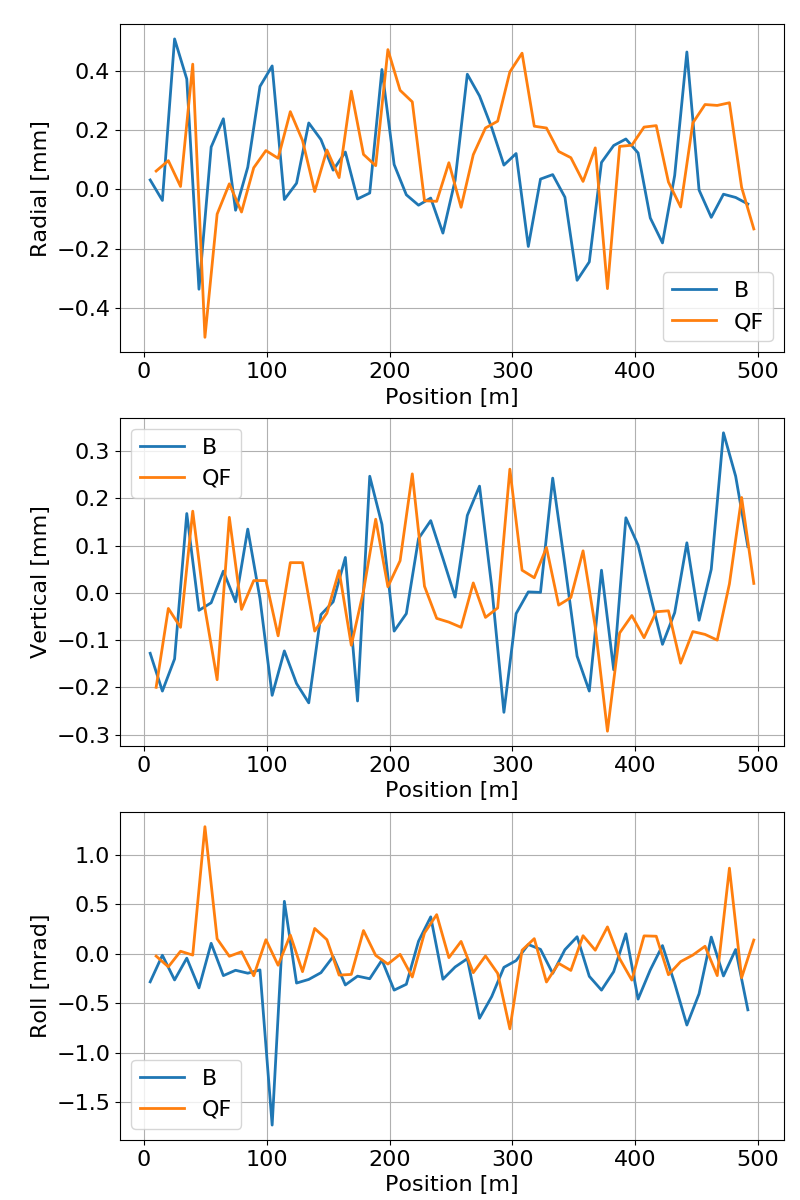

In [31]:
f  = plt.figure(figsize=(8, 12))
gs = mpl_gs.GridSpec(3, 1)
gs.update(left=0.15, right=0.98, top=0.98, bottom=0.05)

labels = {'x': 'Radial', 'z': 'Vertical', 'y': 'Longitudinal', 'roll': 'Roll'}
unit = {'x': 'mm', 'z': 'mm', 'y': 'mm', 'roll': 'mrad'}

for i, err in enumerate(['x', 'z', 'roll']):
    ax = plt.subplot(gs[i, 0])
    ax.grid(True)
    for mag in ['B', 'QF']:
        ax.plot(pos[mag], errs[err][mag], label=mag)
        ax.set_ylabel(labels[err] + ' ['+unit[err]+']')
        ax.set_xlabel('Position [m]')
    ax.legend()
f.show()
f.savefig('bo_alignment_errors_b_qf.png')

# Not ready yet

In [29]:
def calc_fitting(pos, amps, phases, harms):
    val = np.zeros(errors.shape)
    for amp, pha, harm in zip(amps, phases, harms):
        val += amp*np.cos(fund*harm*pos + pha)
    return val


def fun(x, errors, pos, harms):
    n = len(x)//2
    amps = x[:n]
    phases = x[n:2*n]
    fund = 2*np.pi/496.8
    val = calc_fitting(pos, amps, phases, harms)
    err = errors - val
    return np.sqrt(np.mean(err*err))
    

def fit_errors(errors, pos, harms=[1,2,3]):
    x = np.zeros(len(harms)*2)
    scyopt.minimize(fun, x, errors, pos, harms)
    